<a href="https://colab.research.google.com/github/alfazick/AppliedLLMCourse/blob/main/ProjectMultiModal6FullBf16Eval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Clean slate and install stable versions

!pip install matplotlib
!pip install hf_transfer

!pip uninstall transformers trl datasets bitsandbytes peft qwen-vl-utils wandb accelerate -y

!pip install transformers==4.46.2 \
             accelerate==1.0.1 \
             peft==0.13.2 \
             bitsandbytes>=0.45.0 \
             datasets==3.0.2 \
             trl==0.11.4 \
             qwen-vl-utils==0.0.8 \
             wandb==0.18.5

!pip install flash-attn --no-build-isolation
!pip install scipy


  Using cached matplotlib-3.10.7-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (11 kB)
  Using cached contourpy-1.3.3-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.60.1-cp312-cp312-manylinux1_x86_64.manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_5_x86_64.whl.metadata (112 kB)
  Using cached kiwisolver-1.4.9-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (6.3 kB)
Using cached matplotlib-3.10.7-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (8.7 MB)
Using cached contourpy-1.3.3-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl (362 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached fonttools-4.60.1-cp312-cp312-manylinux1_x86_64.manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_5_x86_64.whl (4.9 MB)
Using cached kiwisolver-1.4.9-cp312-cp312-manylinux2014_x86_64.manylinux_2

In [ ]:
# Cell 2 - MUST restart kernel
import os
os._exit(0)  # This forces kernel restart


In [ ]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:128,expandable_segments:True"
os.environ["PYTORCH_NO_CUDA_MEMORY_CACHING"] = "1"



In [ ]:
import torch
print("alloc conf:", os.environ.get("PYTORCH_CUDA_ALLOC_CONF"))


alloc conf: max_split_size_mb:128,expandable_segments:True


In [ ]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

In [ ]:
import importlib

# Verify installed versions match requirements
requirements = {
    'torch': '2.4.1',
    'transformers': '4.46.2',
    'trl': '0.11.4',
    'datasets': '3.0.2',
    'bitsandbytes': '0.44.1',
    'peft': '0.13.2',
    'qwen_vl_utils': '0.0.8',
    'wandb': '0.18.5',
    'accelerate': '1.0.1'
}

print("=== VERSION CHECK ===")
for package, expected in requirements.items():
    try:
        module = importlib.import_module(package)
        actual = getattr(module, '__version__', 'unknown')
        status = "✅" if actual == expected else "⚠️"
        print(f"{status} {package}: {actual} (expected: {expected})")
    except ImportError:
        print(f"❌ {package}: NOT INSTALLED (expected: {expected})")

=== VERSION CHECK ===
⚠️ torch: 2.8.0+cu128 (expected: 2.4.1)
✅ transformers: 4.46.2 (expected: 4.46.2)
✅ trl: 0.11.4 (expected: 0.11.4)
✅ datasets: 3.0.2 (expected: 3.0.2)
⚠️ bitsandbytes: 0.48.2 (expected: 0.44.1)
✅ peft: 0.13.2 (expected: 0.13.2)
⚠️ qwen_vl_utils: unknown (expected: 0.0.8)
✅ wandb: 0.18.5 (expected: 0.18.5)
✅ accelerate: 1.0.1 (expected: 1.0.1)


In [ ]:
import torch
import os
from matplotlib import pyplot as plt
from transformers import Qwen2VLForConditionalGeneration, Qwen2VLProcessor,AutoProcessor
from qwen_vl_utils import vision_process,process_vision_info
import peft
import bitsandbytes as bnb
from transformers import BitsAndBytesConfig


In [ ]:
import gc
import time

def clear_memory():
    # Delete variables if they exist in the current global scope
    if 'inputs' in globals(): del globals()['inputs']
    if 'model' in globals(): del globals()['model']
    if 'processor' in globals(): del globals()['processor']
    if 'trainer' in globals(): del globals()['trainer']
    if 'peft_model' in globals(): del globals()['peft_model']
    if 'bnb_config' in globals(): del globals()['bnb_config']
    time.sleep(2)

    # Garbage collection and clearing CUDA memory
    gc.collect()
    time.sleep(2)
    torch.cuda.empty_cache()
    torch.cuda.synchronize()
    time.sleep(2)
    gc.collect()
    time.sleep(2)

    print(f"GPU allocated memory: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")
    print(f"GPU reserved memory: {torch.cuda.memory_reserved() / 1024**3:.2f} GB")

clear_memory()

GPU allocated memory: 0.00 GB
GPU reserved memory: 0.00 GB


In [ ]:
!nvidia-smi

Sun Nov 23 07:17:54 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.124.06             Driver Version: 570.124.06     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 5090        On  |   00000000:41:00.0 Off |                  N/A |
|  0%   31C    P1             58W /  575W |     506MiB /  32607MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
from datasets import load_dataset
dataset_id = "openfoodfacts/nutrition-table-detection"
nutrition_data = load_dataset(dataset_id)

In [ ]:
nutrition_data

DatasetDict({
    train: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'meta', 'objects'],
        num_rows: 1083
    })
    val: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'meta', 'objects'],
        num_rows: 123
    })
})

In [ ]:
# ok assume dataset will have image_id and objects
def populate_data(populating_dic,dataset,key="train"):
    if populating_dic is None:
        populating_dic = dict()

    if key not in dataset:
        print("dataset missing key",key)
        return None


    for point in dataset[key]:
        image_id = point["image_id"]
        raw_boxes = point["objects"]["bbox"]
        # eliminate the problem at the source


        # Fix format immediately: [y,x,y,x] → [x,y,x,y]
        # https://huggingface.co/datasets/openfoodfacts/nutrition-table-detection
        # bbox: List of bounding boxes in the format (y_min, x_min, y_max, x_max).
        # Coordinates are normalized between 0 and 1, using the top-left corner as the origin.

        raw_boxes = point["objects"]["bbox"]
        boxes = torch.as_tensor(
            [
                [x_min, y_min, x_max, y_max]
                for y_min, x_min, y_max, x_max in raw_boxes
            ],
            dtype=torch.float32,
            device="cpu",                # <-- IMPORTANT I caught a bug this data was on gpu
            # so when I decided to load Qwen, I got OOM :)))
        )

        category = point["objects"]["category_name"]
        # image_data = point["image"] # could not keep image too expensive

        populating_dic[image_id] = {

            "boxes":boxes,
            "category":category,
            ##"image_data":image_data

        }

    return populating_dic


In [ ]:
loading_key = "val"

ground_truth = populate_data(None, nutrition_data, key=loading_key)
# ok set and forget :)) ground truth should be solid

In [ ]:
system_message = """You are a Vision Language Model specialized in interpreting visual data from product images.
Your task is to analyze the provided product images and detect the nutrition tables in a certain format.
Focus on delivering accurate, succinct answers based on the visual information. Avoid additional explanation unless absolutely necessary."""

prompt = "Detect the bounding boxes of the nutrition table in this image and respond in <|bbox|> format <|bbox|>, provide multiple boxes if present "


def generate_messages(image_link):
    messages = [
        {
            "role": "system",
            "content": [{"type": "text", "text": system_message}]
        },
        {
            "role":"user",
            "content":[
                {
                    "type":"image","image":image_link,

                },
                {
                    "type":"text","text":prompt
                },
            ]
        }
    ]
    return messages


def run_inference(image_link):
    torch.cuda.empty_cache()
    messages = generate_messages(image_link)

    text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    image_inputs, video_inputs = process_vision_info(messages)

    inputs = processor(
        text=[text],
        images=image_inputs,
        videos=video_inputs,
        padding=True,
        return_tensors="pt"
    ).to(model.device)

    # 1. Capture input lengths BEFORE generation/deletion
    input_len = inputs.input_ids.shape[1]

    with torch.inference_mode():
        generated_ids = model.generate(**inputs,
                                       max_new_tokens=128,
                                       do_sample=False,  # Greedy decoding is faster
                                       use_cache=True)    # Enable KV cache

    # 2. NOW you can safely delete inputs to free VRAM
    del inputs
    torch.cuda.empty_cache()

    # 3. Use the pre-calculated length to trim
    # Note: Since batch size is 1, we can simplify the list comprehension
    generated_ids_trimmed = [out_ids[input_len:] for out_ids in generated_ids]

    output_text = processor.batch_decode(generated_ids_trimmed, skip_special_tokens=True)
    result = output_text[0]

    # Cleanup
    del generated_ids, generated_ids_trimmed, image_inputs, video_inputs, text, messages
    torch.cuda.empty_cache()

    return result



In [ ]:
# === MODEL SETUP (run once) ===
def load_qwen_model():

    processor = AutoProcessor.from_pretrained("Qwen/Qwen2-VL-7B-Instruct")
    model = Qwen2VLForConditionalGeneration.from_pretrained(
        "Qwen/Qwen2-VL-7B-Instruct",
        torch_dtype=torch.bfloat16,
        device_map="auto",
        attn_implementation="flash_attention_2",
    )
    model.eval()
    return model, processor



# === INFERENCE PIPELINE ===
def predict_bbox(image_url, model, processor):
    # Your existing run_inference code
    return run_inference(image_url)

# === MAIN EXECUTION ===
# Load once
model, processor = load_qwen_model()


`Qwen2VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
!nvidia-smi

Sun Nov 23 07:33:57 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.124.06             Driver Version: 570.124.06     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 5090        On  |   00000000:41:00.0 Off |                  N/A |
|  0%   30C    P8             17W /  575W |   16750MiB /  32607MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [ ]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

def draw_bbox_on_image(image, boxes_dict):
    from PIL import Image, ImageDraw
    import requests
    from io import BytesIO
    img_draw = image.copy()
    draw = ImageDraw.Draw(img_draw)
    width, height = img_draw.size

    boxes = boxes_dict["boxes"].numpy() if hasattr(boxes_dict["boxes"], 'numpy') else boxes_dict["boxes"]
    for box in boxes:
        xmin, ymin, xmax, ymax = box
        box_pixel = [xmin * width, ymin * height, xmax * width, ymax * height]
        draw.rectangle(box_pixel, outline="red", width=5)

    return img_draw

In [ ]:
sample = nutrition_data[loading_key][0]
image_url = sample["meta"]["image_url"]
image = sample["image"]  # PIL image
image_id = sample["image_id"]

# Now run prediction
pred_output = predict_bbox(image_url,model, processor)
print(f"Qwen output: {pred_output}")



Qwen output: <|bbox|>0.38, 0.51, 0.7, 0.75


In [ ]:

# Draw prediction on top (green) - need to modify function to accept color
def draw_bbox_on_image(image, boxes_dict, color="red"):
    from PIL import Image, ImageDraw
    import requests
    from io import BytesIO

    img_draw = image.copy()
    draw = ImageDraw.Draw(img_draw)
    width, height = img_draw.size
    boxes = boxes_dict["boxes"].numpy() if hasattr(boxes_dict["boxes"], 'numpy') else boxes_dict["boxes"]
    for box in boxes:
        xmin, ymin, xmax, ymax = box
        draw.rectangle([xmin * width, ymin * height, xmax * width, ymax * height], outline=color, width=5)
    return img_draw



In [ ]:
from tqdm import tqdm
prediction_data_set = {}
for i in tqdm(range(123),desc="Processing images",unit="img"):  # Start with 10 for testing
    sample = nutrition_data[loading_key][i]
    image_id = sample["image_id"]
    image_url = sample["meta"]["image_url"]
    prediction_data_set[image_id] = predict_bbox(image_url, model, processor)
    tqdm.write(f"Processed {image_id}")

print(f"Total predictions: {len(prediction_data_set)}")

Processing images:   1%|          | 1/123 [00:11<23:08, 11.38s/img]

Processed 0041129077641_1


Processing images:   2%|▏         | 2/123 [00:18<17:49,  8.84s/img]

Processed 0070200581159_1


Processing images:   2%|▏         | 3/123 [00:23<14:13,  7.11s/img]

Processed 0064144043064_2


Processing images:   3%|▎         | 4/123 [00:30<13:52,  7.00s/img]

Processed 0051500700167_1


Processing images:   4%|▍         | 5/123 [00:35<12:37,  6.42s/img]

Processed 0016447100951_1


Processing images:   5%|▍         | 6/123 [00:39<11:04,  5.68s/img]

Processed 26195070_4


Processing images:   6%|▌         | 7/123 [00:43<09:41,  5.01s/img]

Processed 0041244641024_3


Processing images:   7%|▋         | 8/123 [00:47<09:09,  4.78s/img]

Processed 26235066_5


Processing images:   7%|▋         | 9/123 [00:51<08:08,  4.28s/img]

Processed 3571492670004_7


Processing images:   8%|▊         | 10/123 [00:53<07:01,  3.73s/img]

Processed 3256224806950_3


Processing images:   9%|▉         | 11/123 [00:59<08:30,  4.56s/img]

Processed 0072417153051_3


Processing images:  10%|▉         | 12/123 [01:05<08:54,  4.82s/img]

Processed 103106_4


Processing images:  11%|█         | 13/123 [01:12<10:07,  5.52s/img]

Processed 20635923_2


Processing images:  11%|█▏        | 14/123 [01:19<10:47,  5.94s/img]

Processed 0072417159152_2


Processing images:  12%|█▏        | 15/123 [01:23<09:56,  5.52s/img]

Processed 3250390768296_4


Processing images:  13%|█▎        | 16/123 [01:33<11:51,  6.65s/img]

Processed 0071479000013_3


Processing images:  14%|█▍        | 17/123 [01:40<11:57,  6.77s/img]

Processed 0011225033674_1


Processing images:  15%|█▍        | 18/123 [01:43<10:05,  5.77s/img]

Processed 7610700946053_2


Processing images:  15%|█▌        | 19/123 [01:49<09:48,  5.66s/img]

Processed 0064100108219_3


Processing images:  16%|█▋        | 20/123 [01:54<09:24,  5.48s/img]

Processed 0073416006102_2


Processing images:  17%|█▋        | 21/123 [01:56<07:46,  4.57s/img]

Processed 26058450_2


Processing images:  18%|█▊        | 22/123 [02:01<08:00,  4.76s/img]

Processed 27429464_2


Processing images:  19%|█▊        | 23/123 [02:06<07:54,  4.75s/img]

Processed 26052656_1


Processing images:  20%|█▉        | 24/123 [02:10<07:34,  4.59s/img]

Processed 26036120_5


Processing images:  20%|██        | 25/123 [02:14<07:17,  4.46s/img]

Processed 0042272005420_2


Processing images:  21%|██        | 26/123 [02:18<06:51,  4.24s/img]

Processed 26191225_2


Processing images:  22%|██▏       | 27/123 [02:24<07:44,  4.84s/img]

Processed 3250391868322_1


Processing images:  23%|██▎       | 28/123 [02:32<08:51,  5.60s/img]

Processed 3222472951582_1


Processing images:  24%|██▎       | 29/123 [02:43<11:20,  7.24s/img]

Processed 0028400160148_3


Processing images:  24%|██▍       | 30/123 [02:48<10:19,  6.67s/img]

Processed 50172436_2


Processing images:  25%|██▌       | 31/123 [02:52<09:07,  5.95s/img]

Processed 3564700435106_1


Processing images:  26%|██▌       | 32/123 [02:59<09:30,  6.27s/img]

Processed 0070852000527_3


Processing images:  27%|██▋       | 33/123 [03:03<08:10,  5.45s/img]

Processed 0074333375531_2


Processing images:  28%|██▊       | 34/123 [03:08<07:57,  5.36s/img]

Processed 0024138012322_3


Processing images:  28%|██▊       | 35/123 [03:15<08:31,  5.82s/img]

Processed 0028400071345_2


Processing images:  29%|██▉       | 36/123 [03:22<08:52,  6.12s/img]

Processed 0041449003153_2


Processing images:  30%|███       | 37/123 [03:29<09:23,  6.56s/img]

Processed 20720162_2


Processing images:  31%|███       | 38/123 [03:36<09:24,  6.64s/img]

Processed 3700003780349_1


Processing images:  32%|███▏      | 39/123 [03:48<11:25,  8.16s/img]

Processed 0037600106252_4


Processing images:  33%|███▎      | 40/123 [04:00<12:58,  9.38s/img]

Processed 0070970471254_2


Processing images:  33%|███▎      | 41/123 [04:05<10:51,  7.94s/img]

Processed 01575118_2


Processing images:  34%|███▍      | 42/123 [04:09<09:12,  6.82s/img]

Processed 0016000264694_1


Processing images:  35%|███▍      | 43/123 [04:12<07:37,  5.71s/img]

Processed 0021000653218_1


Processing images:  36%|███▌      | 44/123 [04:16<06:47,  5.16s/img]

Processed 20840822_1


Processing images:  37%|███▋      | 45/123 [04:23<07:18,  5.62s/img]

Processed 0011156054502_2


Processing images:  37%|███▋      | 46/123 [04:27<06:35,  5.13s/img]

Processed 0016000275348_2


Processing images:  38%|███▊      | 47/123 [04:38<08:48,  6.95s/img]

Processed 0046100001639_2


Processing images:  39%|███▉      | 48/123 [04:41<07:04,  5.66s/img]

Processed 0018627703211_3


Processing images:  40%|███▉      | 49/123 [04:52<09:02,  7.32s/img]

Processed 0073007107140_1


Processing images:  41%|████      | 50/123 [05:03<10:14,  8.42s/img]

Processed 0036200013694_2


Processing images:  41%|████▏     | 51/123 [05:07<08:42,  7.26s/img]

Processed 26191218_2


Processing images:  42%|████▏     | 52/123 [05:10<06:50,  5.78s/img]

Processed 20574369_2


Processing images:  43%|████▎     | 53/123 [05:12<05:40,  4.87s/img]

Processed 26167932_4


Processing images:  44%|████▍     | 54/123 [05:17<05:23,  4.69s/img]

Processed 0049000027624_2


Processing images:  45%|████▍     | 55/123 [05:22<05:30,  4.85s/img]

Processed 20574444_2


Processing images:  46%|████▌     | 56/123 [05:29<06:03,  5.43s/img]

Processed 0038000787270_2


Processing images:  46%|████▋     | 57/123 [05:40<07:55,  7.21s/img]

Processed 0027400264993_1


Processing images:  47%|████▋     | 58/123 [05:47<07:44,  7.15s/img]

Processed 2407968021654_2


Processing images:  48%|████▊     | 59/123 [05:52<06:55,  6.49s/img]

Processed 0014054030715_2


Processing images:  49%|████▉     | 60/123 [05:57<06:23,  6.08s/img]

Processed 50300853_1


Processing images:  50%|████▉     | 61/123 [06:00<05:24,  5.24s/img]

Processed 3250391868322_6


Processing images:  50%|█████     | 62/123 [06:10<06:35,  6.49s/img]

Processed 3410280003832_1


Processing images:  51%|█████     | 63/123 [06:20<07:42,  7.71s/img]

Processed 3230140005024_3


Processing images:  52%|█████▏    | 64/123 [06:24<06:26,  6.56s/img]

Processed 26067674_3


Processing images:  53%|█████▎    | 65/123 [06:31<06:29,  6.72s/img]

Processed 20719159_3


Processing images:  54%|█████▎    | 66/123 [06:43<07:49,  8.24s/img]

Processed 0034000123803_7


Processing images:  54%|█████▍    | 67/123 [06:48<06:42,  7.18s/img]

Processed 3222473615476_3


Processing images:  55%|█████▌    | 68/123 [06:52<05:40,  6.19s/img]

Processed 0067312002832_4


Processing images:  56%|█████▌    | 69/123 [06:56<04:57,  5.51s/img]

Processed 26015637_2


Processing images:  57%|█████▋    | 70/123 [07:00<04:27,  5.05s/img]

Processed 0025616102504_2


Processing images:  58%|█████▊    | 71/123 [07:06<04:50,  5.59s/img]

Processed 20551926_2


Processing images:  59%|█████▊    | 72/123 [07:18<06:10,  7.26s/img]

Processed 0054800010080_3


Processing images:  59%|█████▉    | 73/123 [07:22<05:19,  6.38s/img]

Processed 20117795_2


Processing images:  60%|██████    | 74/123 [07:27<04:55,  6.03s/img]

Processed 0043647020017_2


Processing images:  61%|██████    | 75/123 [07:38<06:04,  7.59s/img]

Processed 0043646210389_1


Processing images:  62%|██████▏   | 76/123 [07:42<04:55,  6.29s/img]

Processed 26117959_7


Processing images:  63%|██████▎   | 77/123 [07:48<04:54,  6.40s/img]

Processed 20165079_2


Processing images:  63%|██████▎   | 78/123 [07:56<05:00,  6.69s/img]

Processed 24632621_4


Processing images:  64%|██████▍   | 79/123 [08:00<04:23,  5.98s/img]

Processed 9300601250240_2


Processing images:  65%|██████▌   | 80/123 [08:08<04:44,  6.62s/img]

Processed 20674540_2


Processing images:  66%|██████▌   | 81/123 [08:19<05:37,  8.04s/img]

Processed 0072878515276_2


Processing images:  67%|██████▋   | 82/123 [08:25<04:54,  7.18s/img]

Processed 3250390023777_3


Processing images:  67%|██████▋   | 83/123 [08:29<04:09,  6.24s/img]

Processed 0037466016450_2


Processing images:  68%|██████▊   | 84/123 [08:32<03:32,  5.44s/img]

Processed 3068320112893_9


Processing images:  69%|██████▉   | 85/123 [08:36<03:10,  5.01s/img]

Processed 93300292_2


Processing images:  70%|██████▉   | 86/123 [08:38<02:34,  4.18s/img]

Processed 2000000033325_2


Processing images:  71%|███████   | 87/123 [08:41<02:12,  3.67s/img]

Processed 00854252_6


Processing images:  72%|███████▏  | 88/123 [08:45<02:14,  3.83s/img]

Processed 01642582_1


Processing images:  72%|███████▏  | 89/123 [08:56<03:24,  6.01s/img]

Processed 0014100074120_2


Processing images:  73%|███████▎  | 90/123 [09:07<04:02,  7.34s/img]

Processed 0038000316104_4


Processing images:  74%|███████▍  | 91/123 [09:18<04:36,  8.64s/img]

Processed 0021000419074_1


Processing images:  75%|███████▍  | 92/123 [09:22<03:46,  7.29s/img]

Processed 3250390768296_3


Processing images:  76%|███████▌  | 93/123 [09:28<03:21,  6.71s/img]

Processed 20298302_2


Processing images:  76%|███████▋  | 94/123 [09:32<02:55,  6.04s/img]

Processed 3284230002240_2


Processing images:  77%|███████▋  | 95/123 [09:36<02:33,  5.47s/img]

Processed 26155432_2


Processing images:  78%|███████▊  | 96/123 [09:41<02:23,  5.32s/img]

Processed 3350031653285_1


Processing images:  79%|███████▉  | 97/123 [09:47<02:16,  5.26s/img]

Processed 0072869110138_3


Processing images:  80%|███████▉  | 98/123 [09:54<02:24,  5.78s/img]

Processed 20520090_2


Processing images:  80%|████████  | 99/123 [10:00<02:26,  6.12s/img]

Processed 20608668_3


Processing images:  81%|████████▏ | 100/123 [10:07<02:23,  6.25s/img]

Processed 0041498000028_3


Processing images:  82%|████████▏ | 101/123 [10:14<02:21,  6.44s/img]

Processed 0052159000073_2


Processing images:  83%|████████▎ | 102/123 [10:18<01:58,  5.65s/img]

Processed 0063667090067_4


Processing images:  84%|████████▎ | 103/123 [10:29<02:29,  7.46s/img]

Processed 0021130079278_2


Processing images:  85%|████████▍ | 104/123 [10:33<02:02,  6.46s/img]

Processed 26101989_3


Processing images:  85%|████████▌ | 105/123 [10:45<02:20,  7.82s/img]

Processed 0016000106406_2


Processing images:  86%|████████▌ | 106/123 [10:50<01:59,  7.04s/img]

Processed 20472313_2


Processing images:  87%|████████▋ | 107/123 [10:54<01:40,  6.26s/img]

Processed 0016000442825_4


Processing images:  88%|████████▊ | 108/123 [11:01<01:37,  6.53s/img]

Processed 20889869_2


Processing images:  89%|████████▊ | 109/123 [11:05<01:18,  5.62s/img]

Processed 26212630_6


Processing images:  89%|████████▉ | 110/123 [11:16<01:33,  7.17s/img]

Processed 3596710458455_7


Processing images:  90%|█████████ | 111/123 [11:18<01:10,  5.84s/img]

Processed 22000279_5


Processing images:  91%|█████████ | 112/123 [11:22<00:56,  5.10s/img]

Processed 8480000342096_3


Processing images:  92%|█████████▏| 113/123 [11:33<01:10,  7.08s/img]

Processed 0030000059708_1


Processing images:  93%|█████████▎| 114/123 [11:38<00:56,  6.29s/img]

Processed 3257984581972_1


Processing images:  93%|█████████▎| 115/123 [11:44<00:49,  6.24s/img]

Processed 0070177067731_2


Processing images:  94%|█████████▍| 116/123 [11:48<00:38,  5.51s/img]

Processed 0058449771807_2


Processing images:  95%|█████████▌| 117/123 [11:51<00:29,  4.93s/img]

Processed 9300601462889_2


Processing images:  96%|█████████▌| 118/123 [11:59<00:28,  5.66s/img]

Processed 0073141152327_2


Processing images:  97%|█████████▋| 119/123 [12:03<00:21,  5.34s/img]

Processed 0071962226104_3


Processing images:  98%|█████████▊| 120/123 [12:10<00:17,  5.79s/img]

Processed 0039000081047_4


Processing images:  98%|█████████▊| 121/123 [12:13<00:09,  4.93s/img]

Processed 26209142_6


Processing images:  99%|█████████▉| 122/123 [12:18<00:04,  4.99s/img]

Processed 20511586_3


Processing images: 100%|██████████| 123/123 [12:25<00:00,  6.06s/img]

Processed 0071921377601_1
Total predictions: 123


In [ ]:
prediction_data_set

{'0041129077641_1': '<|bbox|>0.38, 0.51, 0.7, 0.75',
 '0070200581159_1': '<|bbox|>180, 285, 630, 450</bbox>',
 '0064144043064_2': '<|bbox|>0.01,0.12,0.94,0.81',
 '0051500700167_1': '<|bbox|>0.25 0.25 0.62 0.85',
 '0016447100951_1': '<|bbox|>110,350,600,749</bbox>',
 '26195070_4': '<|bbox|>0.34, 0.23, 0.68, 0.75|>',
 '0041244641024_3': '<|bbox|>0,0,999,999<|bbox|>',
 '26235066_5': '<|bbox|>198,450,840,800<|bbox|>',
 '3571492670004_7': '<|bbox|>0,0,954,618<|bbox|>',
 '3256224806950_3': '<|bbox|>0.04 0.31 0.96 0.81>',
 '0072417153051_3': '<|bbox|>0.32,0.33,0.65,0.81',
 '103106_4': '<|bbox|>0.01 0.17 0.99 0.83>',
 '20635923_2': 'Nutrition Information(500,100),(829,750)',
 '0072417159152_2': 'Nutrition Information(180,160),(608,995)',
 '3250390768296_4': '[0.75, 0.5, 0.89, 0.65]',
 '0071479000013_3': '<|bbox|>100,500,500,800<|bbox|>',
 '0011225033674_1': '<|bbox|>10,250,989,700<|bbox|>',
 '7610700946053_2': '[0.32, 0.63, 0.98, 0.83]',
 '0064100108219_3': '<|bbox|>0.21, 0.21, 0.62, 0.99|>',


In [ ]:
import json

# Save as JSON (since it's just image_id -> string mapping)
with open('predictionsFull.json', 'w') as f:
    json.dump(prediction_data_set, f)

print(f"Saved {len(prediction_data_set)} predictions to predictions.json")

# To load later:
# with open('predictions.json', 'r') as f:
#     prediction_data_set = json.load(f)

Saved 123 predictions to predictions.json


In [ ]:
# ok my mega check function
from scipy.optimize import linear_sum_assignment
from torchvision import ops
def evaluate(dict_predict,dict_ground_truth):
    all_ious = list()

    total_missed_real_boxes = 0
    total_extra_predicted = 0


    common_ids = set(dict_predict.keys()) & set(dict_ground_truth.keys())

    for image_id in common_ids:
        prediction_boxes = dict_predict[image_id]["boxes"]
        ground_truth_boxes = dict_ground_truth[image_id]["boxes"]

        total_predicted_boxes = len(prediction_boxes)
        total_ground_truth_boxes = len(ground_truth_boxes)

        # Calculate IoU matrix
        iou_matrix = ops.box_iou(prediction_boxes,ground_truth_boxes)
        # Hungarian matching
        pred_idx, gt_idx = linear_sum_assignment(-iou_matrix.numpy())

        # Get matched IoUs
        matched_ious = iou_matrix[pred_idx, gt_idx]
        all_ious.extend(matched_ious.tolist())

        # i have a bit doubt about this lines may be abs
        #
        total_missed_real_boxes += total_ground_truth_boxes - len(pred_idx)
        total_extra_predicted += total_predicted_boxes - len(matched_ious)

    return {
        'mean_iou': sum(all_ious) / len(all_ious),
        'missed_gt': total_missed_real_boxes,
        'extra_pred': total_extra_predicted
    }


In [ ]:
def parse_bbox_output(output_text):
    import re
    import ast

    # Clean common issues
    text = output_text.strip()

    # Handle empty predictions
    if text == '[]' or text == '':
        return [[0.0, 0.0, 0.0, 0.0]]

    # Special case: Multiple bboxes (like '[0.0, 0.25, 0.5, 0.75], [0.5, 0.25, 1.0, 0.75]')
    if text.startswith('[') and '], [' in text:
        all_bboxes = re.findall(r'\[([\d., ]+)\]', text)
        bboxes = []
        for bbox_str in all_bboxes:
            bbox = [float(x.strip()) for x in bbox_str.split(',')]
            bboxes.append(bbox)
        return bboxes  # Return list of bboxes

    # Single bbox - parse and return as single-element list for consistency
    bbox = None

    # Case 1: <|bbox|> format (most common)
    if '<|bbox|>' in text:
        match = re.search(r'<\|bbox\|>(.*?)(?:</?(?:\|?bbox\|?)?>|\|>|>|$)', text)
        if match:
            bbox_str = match.group(1).strip()
            bbox_str = bbox_str.rstrip('<')
            bbox_str = bbox_str.rstrip(')')
            values = [float(x.strip()) for x in re.split(r'[,\s]+', bbox_str) if x.strip()]

            if len(values) == 4:
                if any(x > 1 for x in values):
                    bbox = [x/1000 for x in values]
                else:
                    bbox = values

    # Case 2: Bracket format [x1, y1, x2, y2]
    elif text.startswith('[') and text.endswith(']'):
        try:
            bbox = ast.literal_eval(text)
        except:
            pass

    # Case 3: "Nutrition/nutrition" format with coordinates
    elif re.search(r'[Nn]utrition', text, re.IGNORECASE):
        match = re.findall(r'\((\d+),(\d+)\)', text)
        if len(match) == 2:
            x1, y1 = map(float, match[0])
            x2, y2 = map(float, match[1])
            bbox = [x1/1000, y1/1000, x2/1000, y2/1000]

    # Fallback: try to extract any 4 numbers
    if bbox is None:
        # Clean up common malformed endings
        text_cleaned = text.rstrip(')')  # Remove trailing parenthesis

        numbers = re.findall(r'\d+\.?\d*', text_cleaned)
        if len(numbers) >= 4:
            values = [float(n) for n in numbers[:4]]
            if any(x > 1 for x in values):
                bbox = [x/1000 for x in values]
            else:
                bbox = values

    if bbox is not None:
        return [bbox]  # Return as list for consistency

    raise ValueError(f"Could not parse: {text}")


In [ ]:
# Reparse all predictions with the robust parser
predictions_parsed = {}
failed = []
multi_box_images = []

for image_id, pred_string in prediction_data_set.items():
    try:
        bboxes = parse_bbox_output(pred_string)  # This returns a list of bboxes

        # Track images with multiple boxes
        if len(bboxes) > 1:
            multi_box_images.append((image_id, len(bboxes)))

        predictions_parsed[image_id] = {
            "boxes": torch.tensor(bboxes, dtype=torch.float32),  # No extra brackets!
            "category": ["nutrition_table"] * len(bboxes)  # One category per box
        }
    except Exception as e:
        failed.append((image_id, pred_string))
        print(f"Failed {image_id}: {str(e)[:50]}")
        # Add a default box for failed parsing
        predictions_parsed[image_id] = {
            "boxes": torch.tensor([[0.1, 0.1, 0.9, 0.9]], dtype=torch.float32),
            "category": ["nutrition_table"]
        }

print(f"Successfully parsed: {len(predictions_parsed)}/{len(prediction_data_set)}")
if multi_box_images:
    print(f"Images with multiple boxes: {len(multi_box_images)}")
    for img_id, count in multi_box_images[:3]:  # Show first 3
        print(f"  {img_id}: {count} boxes")
if failed:
    print(f"Failed to parse: {len(failed)}")

# Re-run evaluation with properly parsed predictions
results = evaluate(predictions_parsed, ground_truth)
print("\nEvaluation Results:")
print(f"  Mean IoU: {results['mean_iou']:.3f}")
print(f"  Missed GT boxes: {results['missed_gt']}")
print(f"  Extra predicted: {results['extra_pred']}")

Successfully parsed: 123/123

Evaluation Results:
  Mean IoU: 0.550
  Missed GT boxes: 7
  Extra predicted: 0


Text(0.5, 1.0, '0041129077...\nIoU: 0.31')

(np.float64(-0.5), np.float64(3119.5), np.float64(4207.5), np.float64(-0.5))

Text(0.5, 1.0, '0070200581...\nIoU: 0.59')

(np.float64(-0.5), np.float64(2447.5), np.float64(3263.5), np.float64(-0.5))

Text(0.5, 1.0, '0064144043...\nIoU: 0.90')

(np.float64(-0.5), np.float64(1999.5), np.float64(2665.5), np.float64(-0.5))

Text(0.5, 1.0, '0051500700...\nIoU: 0.54')

(np.float64(-0.5), np.float64(2447.5), np.float64(3263.5), np.float64(-0.5))

Text(0.5, 1.0, '0016447100...\nIoU: 0.53')

(np.float64(-0.5), np.float64(1999.5), np.float64(2696.5), np.float64(-0.5))

Text(0.5, 1.0, '26195070_4...\nIoU: 0.69')

(np.float64(-0.5), np.float64(1999.5), np.float64(1124.5), np.float64(-0.5))

Text(0.5, 1.0, '0041244641...\nIoU: 0.35')

(np.float64(-0.5), np.float64(1674.5), np.float64(1199.5), np.float64(-0.5))

Text(0.5, 1.0, '26235066_5...\nIoU: 0.88')

(np.float64(-0.5), np.float64(1124.5), np.float64(1999.5), np.float64(-0.5))

Text(0.5, 1.0, '3571492670...\nIoU: 0.93')

(np.float64(-0.5), np.float64(952.5), np.float64(1199.5), np.float64(-0.5))

Text(0.5, 1.0, '3256224806...\nIoU: 0.38')

(np.float64(-0.5), np.float64(787.5), np.float64(490.5), np.float64(-0.5))

Text(0.5, 0.98, 'All 10 Predictions - Red=GT, Green=Prediction')

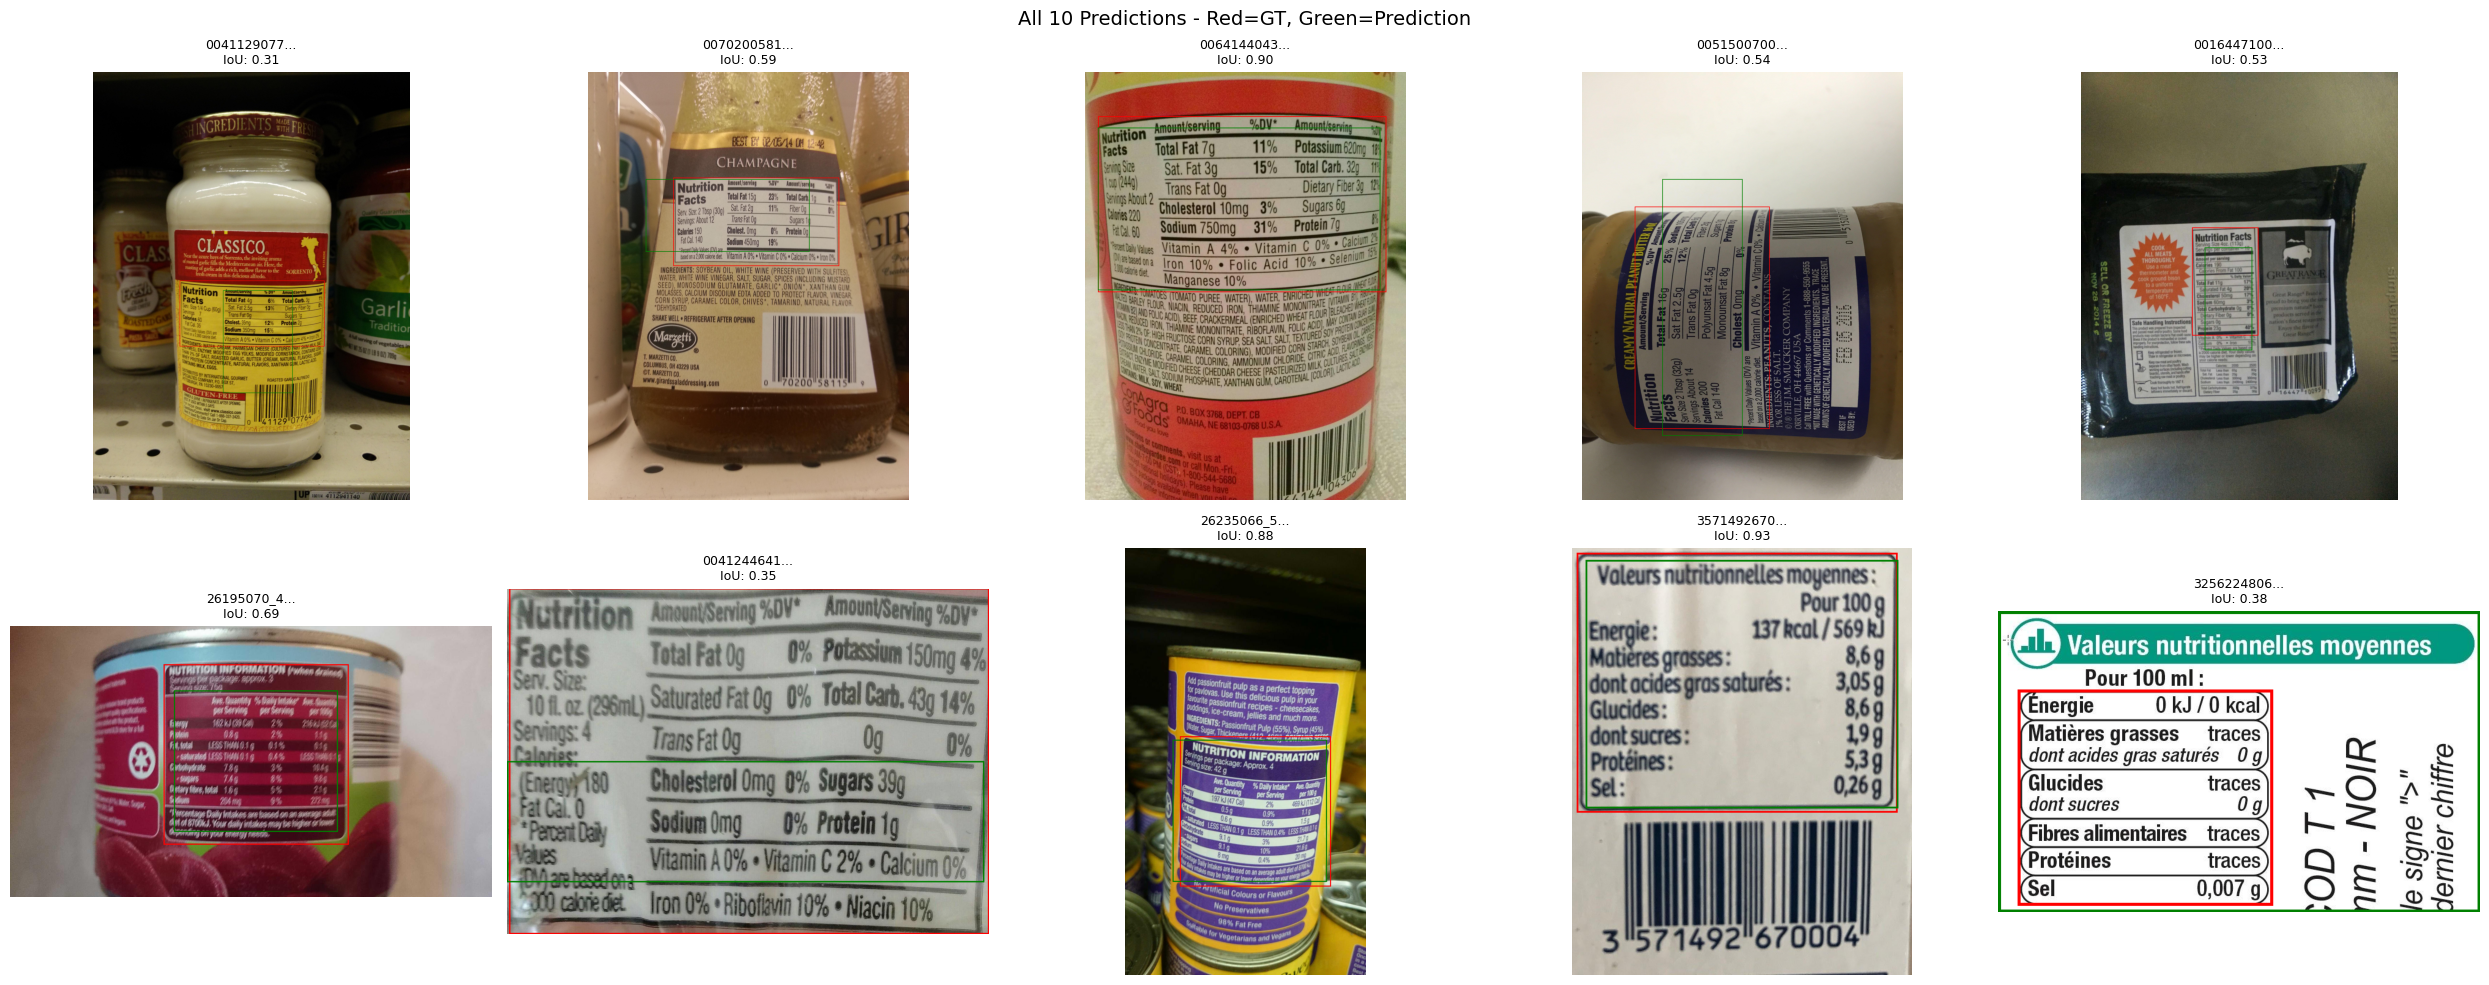

In [ ]:
import json
import matplotlib.pyplot as plt
from torchvision import ops

# Load predictions from file
with open('predictions.json', 'r') as f:
    prediction_data_set = json.load(f)

# Get all 10 image IDs
image_ids = list(prediction_data_set.keys())[:10]

fig, axes = plt.subplots(2, 5, figsize=(25, 10))
axes = axes.flatten()

for idx, image_id in enumerate(image_ids):
    # Find sample
    for sample in nutrition_data[loading_key]:
        if sample["image_id"] == image_id:
            break

    # Parse prediction with robust parser
    parsed_boxes = parse_bbox_output(prediction_data_set[image_id])  # Returns list
    pred_dict = {
        "boxes": torch.tensor(parsed_boxes, dtype=torch.float32),  # No extra brackets!
        "category": ["nutrition_table"] * len(parsed_boxes)  # One per box
    }

    # Draw using your function
    img_with_gt = draw_bbox_on_image(sample["image"], ground_truth[image_id], "red")
    final_img = draw_bbox_on_image(img_with_gt, pred_dict, "green")

    # Calculate IoU (handle multiple boxes)
    if len(pred_dict['boxes']) > 0 and len(ground_truth[image_id]['boxes']) > 0:
        # Get best IoU for display (or mean)
        iou_matrix = ops.box_iou(pred_dict['boxes'], ground_truth[image_id]['boxes'])
        iou = iou_matrix.max().item()  # Best match IoU
        # Or use mean of best matches:
        # iou = iou_matrix.max(dim=1)[0].mean().item()
    else:
        iou = 0.0

    axes[idx].imshow(final_img)

    # Show if multiple boxes detected
    num_pred = len(pred_dict['boxes'])
    num_gt = len(ground_truth[image_id]['boxes'])
    title = f"{image_id[:10]}...\nIoU: {iou:.2f}"
    if num_pred > 1 or num_gt > 1:
        title += f" (P:{num_pred}/GT:{num_gt})"

    axes[idx].set_title(title, fontsize=9)
    axes[idx].axis('off')

plt.suptitle("All 10 Predictions - Red=GT, Green=Prediction", fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
# ok so this version load in bf16 Mean IoU: 0.550

